In [21]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import roboscientist.equation.equation as rs_equation
from experiments import run_experiment

import roboscientist.equation.operators as rs_operators
from scipy.special import lambertw



In [22]:
# first tune wandb logs to your account (wandb_key file)

In [26]:
# in experiments.py comment 122-126 lines

In [22]:

# this function returns left and right offsprings of a given token (polish notation)
# works for token with arity less or =  2

def get_sub_trees_of_binary(list_of_tokens, idx):
    if list_of_tokens[idx] in rs_operators.OPERATORS:
        open_nodes = rs_operators.OPERATORS[list_of_tokens[idx]].arity
    else:
        open_nodes = 0
    left, right = [], []
    current_sub_tree = left
    for i, token in enumerate(list_of_tokens[idx + 1:]):
        if open_nodes == 0:
            break
        if open_nodes == 1:
            current_sub_tree = right
        current_sub_tree.append(token)

        if token in rs_operators.OPERATORS:
            operator = rs_operators.OPERATORS[token]
            open_nodes += operator.arity - 1
        else:
            open_nodes -= 1
    return left, right




In [ ]:
# this function of predicate of polynomial shape 

def predicate_poly_relation(list_of_tokens):
    if list_of_tokens[0] != 'div':
        return False
    for i, token in enumerate(list_of_tokens):
        offsprings = get_offsprings(list_of_tokens, i)
        if token == 'sin' or token == 'cos' or token == 'ln' or token == 'log':
            return False
        if token == 'pow':
            left, right = get_sub_trees_of_binary(list_of_tokens, i)
            if right not in rs_operators.FLOAT_CONST:
                return False

    return True


In [23]:

# this function returns offsprings of a given token

def get_offsprings(list_of_tokens, idx):
    if list_of_tokens[idx] in rs_operators.OPERATORS:
        open_nodes = rs_operators.OPERATORS[list_of_tokens[idx]].arity
    else:
        open_nodes = 0
    traversal = []
    for i, token in enumerate(list_of_tokens[idx + 1:]):
        if open_nodes == 0:
            break
        traversal.append(token)
        if token in rs_operators.OPERATORS:
            operator = rs_operators.OPERATORS[token]
            open_nodes += operator.arity - 1
        else:
            open_nodes -= 1

    return traversal


# this is a predicate function that  

def predicate(list_of_tokens):
    for i, token in enumerate(list_of_tokens):
        offsprings = get_offsprings(list_of_tokens, i)
        if  token == 'LWF' :
            if  'LWF' in offsprings :
                return False
        if token == 'sin' or token == 'cos' or token == 'log'  or token == 'exp':
            
                return False
        if token == 'pow':
            left, right = get_sub_trees_of_binary(list_of_tokens, i)
            if right not in rs_operators.FLOAT_CONST:
                return False
    return True


In [24]:

# load your date 
# here example baset on real data glucose(t) 
# link: https://www.notion.so/Datasets-1928ae7279f34008989c2ea91ca528e7
# x_time_mask.npz

time = np.load('../time.npy')
glucoze =  np.load('../glucose.npy')
mask = np.load('../mask.npy')
meta = np.load('../meta.npy')
#print(time)
#print(glucoze)
#print(mask)
#print(meta)
#mask  = mask == 1
#print(glucoze[0][mask[0]])
#print(time [mask[0]])




[   0.           19.55         21.51666667   23.46666667   35.13333333
   38.78333333   42.46666667   51.23333333   54.31666667   57.4
   72.88333333   75.76666667   78.63333333  134.53333333  137.41666667
  140.28333333  195.56666667  198.43333333  201.31666667  286.55
  289.43333333  292.3         347.81666667  350.7         353.58333333
  446.6         449.48333333  452.35        609.56666667  612.45
  614.86666667 1297.68333333 1300.56666667 1303.45       1657.76666667
 1660.63333333 1662.88333333]
[[ 0.       0.0674   0.       0.       0.11431  0.       0.       0.15727
   0.       0.       0.43397  0.       0.       0.37199  0.       0.
   0.58389  0.       0.       0.82851  0.       0.       0.97426  0.
   0.       1.29141  0.       0.       1.74963  0.       0.       3.62329
   0.       0.       4.34174  0.       0.     ]
 [ 0.       0.17929  0.       0.       0.30045  0.       0.       0.43431
   0.       0.       1.23667  0.       0.       1.0727   0.       0.
   1.69257  0. 

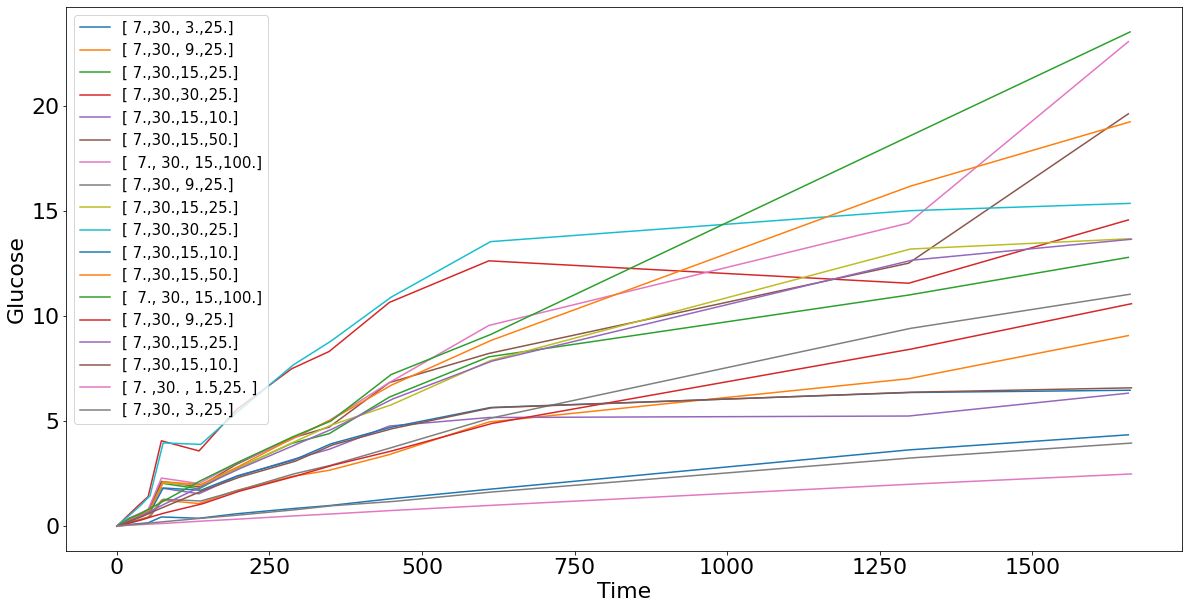

In [19]:
# glucose over time plot


import matplotlib.pyplot as plt

from matplotlib.pyplot import figure


for i in range(18):

    X = time[mask[i]]


    y = glucoze[i][mask[i]]


    metad = np.array2string(meta[i], precision=2, separator=',',
                      suppress_small=True) 
    
    
    plt.plot(X,y,label=metad)

    plt.xlabel("Time")
plt.ylabel("Glucose")
  
plt.legend(loc="upper left",prop={'size': 15})

#plt.rcParams["figure.figsize"] = (20,10)  
#figure(figsize=(50, 50), dpi=10)
#plt.rcParams.update({'font.size': 22})
    

In [25]:
# here as an example chosen a subset of data with fixet initial experiment paraneters 


X = time[mask[9]]

X=np.array(X)[..., None]
    
y = glucoze[9][mask[9]]
    
y=np.array(y)

In [29]:


# before to run segvae make sure that you have added all functions listed in labriary - here new 'LWF'

# to do so add Lambert W function W(z) in to operators.py file

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lambertw.html


solver = run_experiment(X, y,
        functions=['add', 'sub', 'mul', 'sqrt', 'div', 'pow2','pow', 'LWF'],
        free_variables=['x1'],
        wandb_proj='SEGVAE',
        project_name='x_time_mask_9',
        constants=[],
        float_constants=rs_operators.FLOAT_CONST,
     #float_constants=None,
        epochs=100,
        n_formulas_to_sample=5000,
        max_formula_length=20,
        formula_predicate=predicate,
        #true_formula=rs_equation.Equation(true_func),
        latent=128,
        lstm_hidden_dim=64,
        device='cuda',
        train_size=40000,
        log_intermediate_steps=True,
        pretrain_path=None)

best_log_mean_mse_top_1,██████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
best_log_mean_mse_top_10,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
best_log_mean_mse_top_100,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
best_log_mean_mse_top_25,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_log_mean_mse_top_250,█▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
best_log_mean_mse_top_50,█▆▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_log_mean_mse_top_500,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
best_mean_mse_top_1,██████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
best_mean_mse_top_10,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_mean_mse_top_100,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_mean_mse_top_25,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


===== START PRETRAIN =====
	[training] batches count: 157
	[training] loss: 22.248, rec loss: 22.150, kl: 0.194
	[validation] loss: 19.002, rec loss: 18.985, kl: 0.035
	[training] batches count: 157
	[training] loss: 19.722, rec loss: 19.704, kl: 0.036
	[validation] loss: 17.904, rec loss: 17.896, kl: 0.016
	[training] batches count: 157
	[training] loss: 18.951, rec loss: 18.938, kl: 0.026
	[validation] loss: 17.429, rec loss: 17.418, kl: 0.021
	[training] batches count: 157
	[training] loss: 18.588, rec loss: 18.568, kl: 0.041
	[validation] loss: 17.195, rec loss: 17.169, kl: 0.053
	[training] batches count: 157
	[training] loss: 18.377, rec loss: 18.334, kl: 0.087
	[validation] loss: 17.092, rec loss: 17.035, kl: 0.114
	[training] batches count: 157
	[training] loss: 18.285, rec loss: 18.210, kl: 0.149
	[validation] loss: 17.114, rec loss: 17.019, kl: 0.190
	[training] batches count: 157
	[training] loss: 18.217, rec loss: 18.122, kl: 0.190
	[validation] loss: 16.983, rec loss: 16.8

	[training] batches count: 2
	[training] loss: 22.655, rec loss: 20.884, kl: 3.542
	[validation] loss: 22.607, rec loss: 20.729, kl: 3.756
	[training] batches count: 2
	[training] loss: 21.773, rec loss: 19.959, kl: 3.627
	[validation] loss: 21.442, rec loss: 19.680, kl: 3.525
	[training] batches count: 2
	[training] loss: 21.557, rec loss: 19.768, kl: 3.578
	[validation] loss: 21.116, rec loss: 19.246, kl: 3.741
	[training] batches count: 2
	[training] loss: 20.795, rec loss: 18.976, kl: 3.637
	[validation] loss: 20.389, rec loss: 18.624, kl: 3.531
	[training] batches count: 2
	[training] loss: 20.696, rec loss: 18.936, kl: 3.521
	[validation] loss: 20.471, rec loss: 18.729, kl: 3.484
	[training] batches count: 2
	[training] loss: 21.852, rec loss: 20.094, kl: 3.517
	[validation] loss: 21.474, rec loss: 19.739, kl: 3.470
	[training] batches count: 2
	[training] loss: 23.518, rec loss: 21.729, kl: 3.578
	[validation] loss: 23.161, rec loss: 21.352, kl: 3.617
	[training] batches count: 

	[training] batches count: 2
	[training] loss: 24.709, rec loss: 23.169, kl: 3.079
	[validation] loss: 24.098, rec loss: 22.545, kl: 3.106
	[training] batches count: 1
	[training] loss: 17.495, rec loss: 16.097, kl: 2.796
	[validation] loss: 17.437, rec loss: 16.034, kl: 2.805
	[training] batches count: 1
	[training] loss: 17.862, rec loss: 16.475, kl: 2.775
	[validation] loss: 17.655, rec loss: 16.254, kl: 2.802
	[training] batches count: 1
	[training] loss: 18.063, rec loss: 16.687, kl: 2.751
	[validation] loss: 17.707, rec loss: 16.313, kl: 2.787
	[training] batches count: 1
	[training] loss: 18.079, rec loss: 16.693, kl: 2.771
	[validation] loss: 17.946, rec loss: 16.556, kl: 2.780
	[training] batches count: 1
	[training] loss: 18.103, rec loss: 16.731, kl: 2.745
	[validation] loss: 17.821, rec loss: 16.444, kl: 2.754
	[training] batches count: 2
	[training] loss: 28.913, rec loss: 27.286, kl: 3.254
	[validation] loss: 27.888, rec loss: 26.190, kl: 3.395
	[training] batches count: 

In [27]:
best_idx = np.argmin(solver.stats.last_n_best_mses)
equations = np.array(solver.stats.last_n_best_formulas)
eq = rs_equation.Equation(equations[best_idx].split())

In [28]:
print('Raw equation in prefix notation: ', equations[best_idx])
print('Equation in traditional notation: ', eq.repr())

Raw equation in prefix notation:  pow2 LWF div add 3.0 x1 7.0
Equation in traditional notation:  ((LWF(((3.0 + x1) / 7.0)))^2)
